In [1]:
%reload_ext autoreload
%autoreload 2

#set cuda visible to only #3 GPU
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0,1,2,3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0,1,2,3


In [2]:
!nvidia-smi

Sun Feb 12 20:06:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  On   | 00000000:18:00.0 Off |                    0 |
| N/A   30C    P0    34W / 250W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-PCI...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   

In [3]:
import dnnlib
import torch
import legacy
from training.networks_stylegan3 import Generator
network_pkl = "pretrained/stylegan3-r-ffhq-1024x1024.pkl"
device = torch.device('cuda')
# with dnnlib.util.open_url(network_pkl) as f:
#     G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

In [4]:
import pickle

with open('testa/settings.pkl', 'rb') as f:
    settings = pickle.load(f)
from training.training_loop import training_loop

In [5]:
from training.training_loop import training_loop

In [17]:
!source sh/r4m.sh
training_loop(**settings)

1832.27s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Autoloading gmp/6.2.1/gcc-7.5.0-2px2tki
Autoloading mpc/1.1.0/gcc-7.5.0-osodvlz
Autoloading mpfr/4.1.0/gcc-7.5.0-ublhnmp
Autoloading zlib/1.2.11/gcc-7.5.0-h3xiplk
Autoloading zstd/1.5.0/gcc-7.5.0-qsdxtru
Autoloading cuda/10.2.89/gcc-7.5.0-jr6kobf
Autoloading libxml2/2.9.9/gcc-7.5.0-ouvtc2l
Autoloading libiconv/1.16/gcc-7.5.0-pndwbk6
Autoloading xz/5.2.4/gcc-7.5.0-55h4brm
Autoloading zlib/1.2.11/gcc-7.5.0-dsnnbcq
Autoloading libxml2/2.9.12/gcc-7.5.0-i2j2pf5
Autoloading libiconv/1.16/gcc-7.5.0-cvte7wx
Autoloading xz/5.2.5/gcc-7.5.0-sytpwnz
Autoloading zlib/1.2.11/gcc-7.5.0-h3xiplk
>CUDA_HOME: /sw/workstations/apps/linux-ubuntu18.04-ivybridge/cuda/11.5.0/gcc-7.5.0/syen6pj6ss3cw66zlj4wkfhtixh5i4ei
Loading training set...

Num images:  1260
Image shape: [3, 1024, 1024]
Label shape: [0]

Loading patch dataset...

Patch Num images:  1260
Patch Image shape: [3, 1024, 1024]
Patch Label shape: [0]

Constructing networks...
Using specified img resolution: 1024
cutoffs=array([  2.        ,   3.17

ImportError: /home/cvejica/.cache/torch_extensions/py38_cu113/bias_act_plugin/3cb576a0039689487cfba59279dd6d46-nvidia-a100-pcie-40gb/bias_act_plugin.so: cannot open shared object file: No such file or directory

In [12]:
# from training import training_loop
# training_loop.training_loop(rank=0, **settings)
settings.keys()

dict_keys(['G_kwargs', 'D_kwargs', 'G_opt_kwargs', 'D_opt_kwargs', 'loss_kwargs', 'data_loader_kwargs', 'training_set_kwargs', 'patch_kwargs', 'added_kwargs', 'num_gpus', 'batch_size', 'batch_gpu', 'metrics', 'total_kimg', 'kimg_per_tick', 'image_snapshot_ticks', 'network_snapshot_ticks', 'random_seed', 'ema_kimg', 'ada_kimg', 'ema_rampup', 'run_dir'])

In [5]:
from torch_utils import misc
training_set_kwargs = settings['training_set_kwargs']
data_loader_kwargs = settings['data_loader_kwargs']
batch_size = settings['batch_size']
batch_gpu = settings['batch_gpu']
num_gpus = settings['num_gpus']
random_seed = settings['random_seed']
rank = settings.get('rank', 0)

training_set = dnnlib.util.construct_class_by_name(**training_set_kwargs) # subclass of training.dataset.Dataset
training_set_sampler = misc.InfiniteSampler(dataset=training_set, rank=rank, num_replicas=num_gpus, seed=random_seed)
training_set_iterator = iter(torch.utils.data.DataLoader(dataset=training_set, sampler=training_set_sampler, batch_size=batch_size//num_gpus, **data_loader_kwargs))


In [6]:
patch_kwargs = settings['patch_kwargs']
patch_kwargs.scale_min = 1 # added because was forgotten in settings

patch_dset = dnnlib.util.construct_class_by_name(**patch_kwargs) # subclass of training.dataset.Dataset
patch_dset_sampler = misc.InfiniteSampler(dataset=patch_dset, rank=rank, num_replicas=num_gpus, seed=random_seed)
patch_dset_iterator = iter(torch.utils.data.DataLoader(dataset=patch_dset, sampler=patch_dset_sampler, batch_size=batch_size//num_gpus, **data_loader_kwargs))

In [7]:
from util import patch_util
added_kwargs = settings['added_kwargs']
# 1
phase_real_img, phase_real_c = next(training_set_iterator)
n = phase_real_img.shape[0]
phase_real_img = (phase_real_img.to(device).to(torch.float32) / 127.5 - 1).split(batch_gpu)
phase_real_c = phase_real_c.to(device).split(batch_gpu)
transform = torch.eye(3)[None]
phase_transform = transform.repeat(n, 1, 1).to(device).split(batch_gpu)
min_scale = 1.0
max_scale = 1.0
# if use_hr, we are going to generate random split_range, and coresponding coordinates
# this will be later used to crop the original image?
# produce 
if added_kwargs.use_hr:
    split_range_values = patch_util.generate_random_positions_tensor(n)
    coords = patch_util.grid2pixel_tensor(split_range_values.clone(), 256, 64).split(batch_gpu)
    split_range = split_range_values.split(batch_gpu)

In [8]:
## PATCH data
data, phase_real_c = next(patch_dset_iterator)
phase_real_img = (data['image'].to(device).to(torch.float32) / 127.5 - 1).split(batch_gpu)
phase_real_c = phase_real_c.to(device).split(batch_gpu)
phase_transform = data['params']['transform'].to(device).split(batch_gpu)
split_range_data = torch.stack(data['params']['split_range']).permute(1,0).to(device)
coords = patch_util.grid2pixel_tensor(split_range_data.clone(), 256, 64).split(batch_gpu) #TODO: parameterize this?
split_range = split_range_data.split(batch_gpu)
min_scale = data['params']['min_scale_anneal'][0].item()
max_scale = 1.0

In [50]:
## multiply each value by 4
coords = [c*4 for c in coords]

In [51]:
coords

[tensor([[1536,  512, 2560, 1536],
         [ 768, 1280, 1792, 2304]], device='cuda:0'),
 tensor([[2304,    0, 3328, 1024],
         [ 256, 2560, 1280, 3584]], device='cuda:0')]

In [52]:
data['params']['name']

['shutterstock_1016850124_01.png',
 'shutterstock_2137467927_01.png',
 'shutterstock_1276318882_01.png',
 'shutterstock_2085557662_01.png']

In [9]:
from torchvision.transforms import ToPILImage

In [10]:
from util import renormalize

In [14]:
import torchvision
torchvision.utils.save_image(phase_real_img[0], 'test.png', range=(-1, 1), normalize=True, nrow=4)

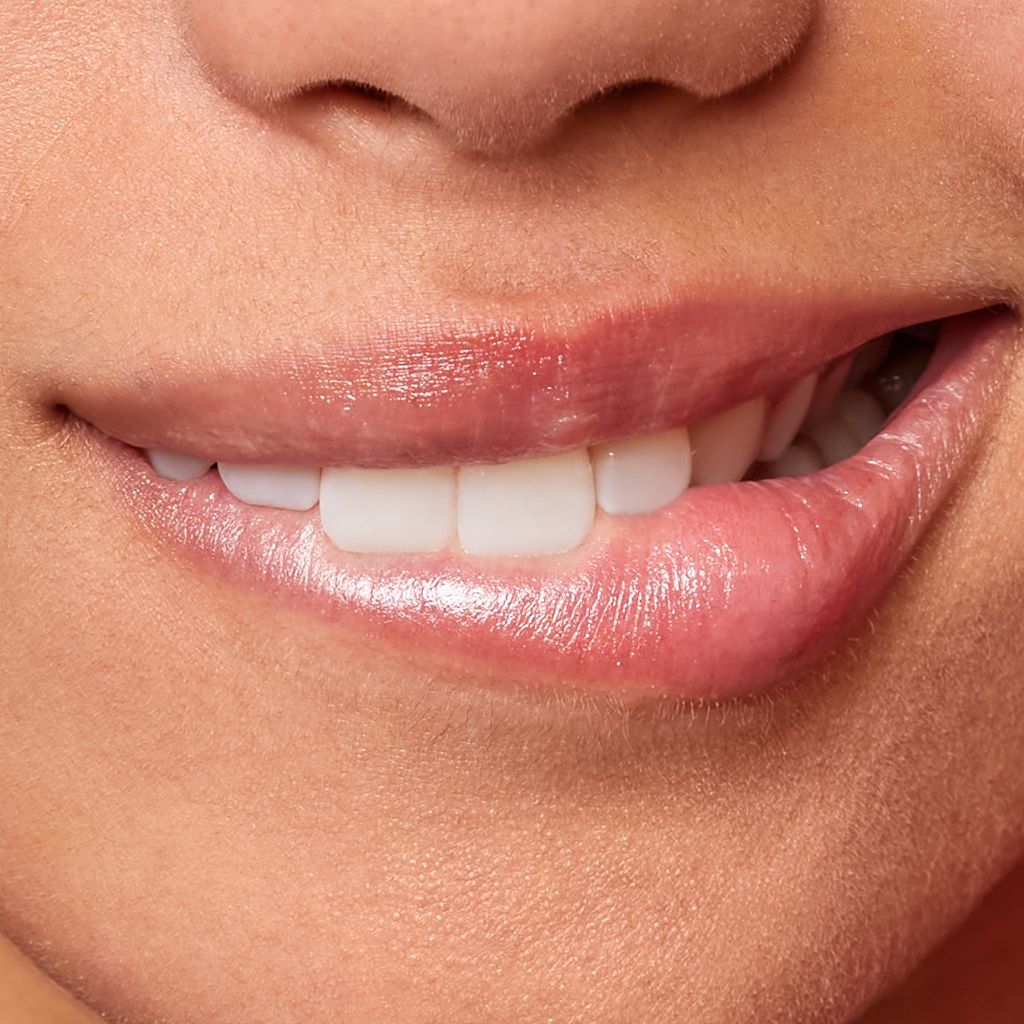

In [11]:
renormalize.as_image(phase_real_img[0][1])

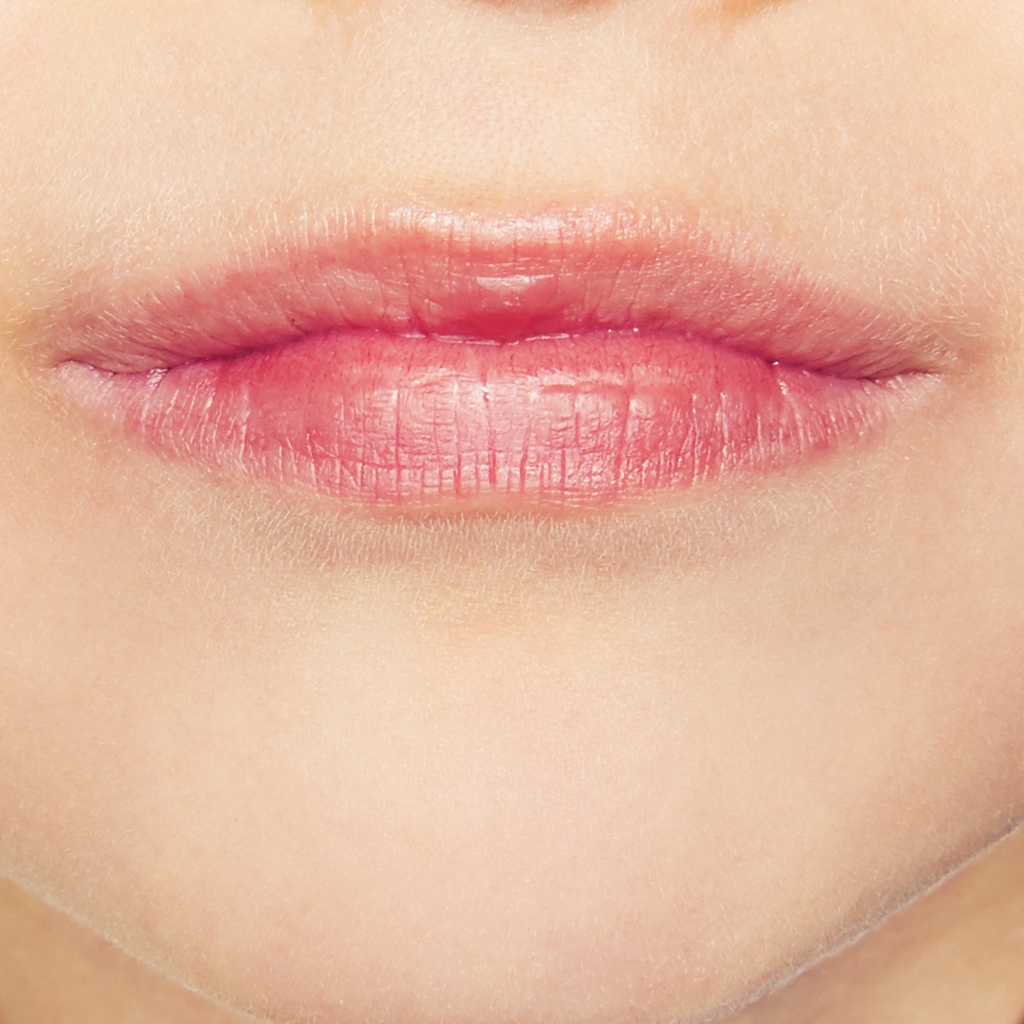

In [46]:
renormalize.as_image(phase_real_img[0][0])

In [20]:
phases = ['Dmain', 'Dreg', 'Gboth']
import numpy as np

In [21]:

all_gen_z = torch.randn([len(phases) * batch_size, 512], device=device) # G.z_dim
all_gen_z = [phase_gen_z.split(batch_gpu) for phase_gen_z in all_gen_z.split(batch_size)]
all_gen_c = [training_set.get_label(np.random.randint(len(training_set))) for _ in range(len(phases) * batch_size)]
all_gen_c = torch.from_numpy(np.stack(all_gen_c)).pin_memory().to(device)
all_gen_c = [phase_gen_c.split(batch_gpu) for phase_gen_c in all_gen_c.split(batch_size)]

In [ ]:
# 